# Caracterización del dataset de stocks de Tesla

Este dataset se obtiene utilizando una [api de yahoo finance](https://github.com/ranaroussi/yfinance) (no ha sido desarrollada por la propia empresa), y contiene información de los precios de cierre de las acciones de Tesla. 

En este notebook se realizará una caracterización de los datos con la intención de obtener información que pueda ser utilizada para la predicción de los precios de los valores de la empresa en bolsa.

In [2]:
import pandas as pd
from summarytools import dfSummary
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#extraer datos de las acciones de tesla desde el 10-4-2022 hasta el 12-11-2022
df = pd.DataFrame(yf.download('TSLA','2022-04-10','2022-11-12'))
df.reset_index(inplace=True)
df.to_csv('../../data/raw/tesla_stocks.csv',index=False)
df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-11,326.799988,336.156677,324.880005,325.309998,325.309998,59357100
1,2022-04-12,332.546661,340.396667,325.533325,328.983337,328.983337,65976000
2,2022-04-13,327.026672,342.079987,324.366669,340.790009,340.790009,55121100
3,2022-04-14,333.096680,337.570007,327.396667,328.333344,328.333344,58422300
4,2022-04-18,329.676666,338.306671,324.470001,334.763336,334.763336,51715200


In [4]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[datetime64[ns]],Min: 2022-04-11Max: 2022-11-11Duration: 214 days,150 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACWklEQVR4nO3Yv27aYBSG8fNhQOaPbCFU2FgyVurgkYvoxfYSOnAFDF06sSEhywgnFsa4SyN1aYid8ILx85s58WfxBB9wZVkaoNC59QHQHsQGme6tD9BUzrmBmfVrjB7Lsnxp4/WIrQbn3GA6nX4PgmBSdXa/38fOuR9VAniU6xFbPf0gCCbL5fIlDMPsvUNJkvir1Wqy2+36Zlbl0+YhrkdsHxCGYTabzZ4rjg3aer03Y/vAc7tjZmfhnHovCc7nc6/GnFxRFD0zC5xzVcaucn//ja3uc7soil6apk/j8fh3p9PJrz1npt9L8jz3i6L4mmXZTzOr+p8vk6ZpL8/zb4vFwvM8792Pw2vd31ufbLWe25vNZrJer79EUfRrPp/H155T7yX/nHV4Op28KnNqx+Ox6/v+MIqirMZ78en3d3Fnq/rcjuN4YGY2Go0kc39J95LXszZF3ffis/GjLmT4Nip2Twu7GrEJ3dvCrkZsQve2sKsR2w3cy8Ku9hCxtXkPapLGx9b2PahJGh9b2/egJml8bK/augc1CT/qQobYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDTPfSC5Ik8av8wcPh4JuZpWnqb7fb4aPNNems6rlLrfwB79iW6IaxmwEAAAAASUVORK5CYII="">",0(0.0%)
2,Open[float64],Mean (sd) : 262.2 (38.6)min < med < max:186.0 < 255.4 < 358.2IQR (CV) : 66.3 (6.8),150 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACtElEQVR4nO3dT4riQBTH8Vdj20SFiAi68wIDs3DpIeawc4RZeAJv4E4QiZjpYIyZ1QwOdPsnlYz5VX8/+8QSfjysyvPFlWVpQNt9efYCgHu8PHsB+Jdzrmdmrx63OJZl+VbXetqCoLaIc643Ho+/x3E8qnqP/X6/c879CC2srQ6qZ3VRrCyvcRyPFovF23A4zB69OEmSaLlcjrbb7auZqX33q1obVN/qolxZhsNhNplMflW8vFfrYlqitUE1j+oScmX5rNocVDPzqi5BVpbPiuMpSCCokEBQIYGgQgJBhQSCCgkEFRIIKiQQVEggqJBAUCGBoEICQYWE1ndPVVUURdfMYudc1VsoNl4HK8igpmnazfP822w263Q6nYc75c20G69DFGRQj8fjSxRF/fl8nk2n092j19N43T5BBvWPwWDAXzoCwWYKEggqJBBUSCCokBD0ZupZPAZnxOfzuVv3ekJAUGvmMzgjz/OoKIqvWZb9NLOqpxVBIqj1qzw4Y71ej1arVf90OnWaWpwqgtqQKoMzdrsdZ7cfYDMFCQQVEggqJDT6G9VzvilHNfirsaD6zjflqAaXmqyoXtOTOarBpcaPp6rON+WoBpfYTEECQYUEggoJBBUSCCokEFRIIKiQQFAhgaBCAkGFBDr8P+AxZE2268uz282swcFyBPUdPkPWVLu+fLvdzJodLEdQ3+EzZE2468ur263pwXIE9YoqQ9bUu7483uZt1uBgOTZTkEBQIYGgQgJBhQSCCgns+gMT6oMKghqQkB9U3Awqsz51hPyg4mpQmfWpKcQHFbcqKrM+0Qp3/UZl1ieejc0UauP5/tmrLYIEFbXwff/srRZBgopa+Jw43NMiSFBRK4/3z17d09wV1CRJokc/9XA4RGZmaZpGm82m/z+vV/1s1XX7Xn9Pvn4DyAey66yUZYYAAAAASUVORK5CYII="">",0(0.0%)
3,High[float64],Mean (sd) : 268.4 (38.6)min < med < max:191.0 < 261.0 < 364.1IQR (CV) : 65.0 (7.0),149 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACuUlEQVR4nO3du47aQBSA4TOwEHORAaFAR5OCIlIKSh4iD5tHSMEDIIo0qeiQAIFwIBjjdBFRNrD22GHO6P96Yxe/vHt8GZs0TQVwXeXZBwC8xcuzDwB/MsY0RKRu8RPnNE2PRR2PKwjVIcaYRr/f/xyGYS/vb+z3+60x5otvsRKqW+phGPam0+mx0+mcsm682+2C2WzWW6/XdREhVJSr0+mcBoPBj5ybNwo9GEcwTEEFp8+oloNFRUSuFrv3cijRytlQbQaLJElqURR9aLfb3yuVSpxn/74OJVo5G6pYDBbL5bK3WCzeTyaTb8PhcJt1xz4PJVq5HKqI5BssttttQ0Sk1WoxlHiCYQoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFDB+Zf7NLJYjyC8Xq+1oo/HB4RaMJv1COI4DpIk+Xg6nb6KSN63Z71EqMWzXY+geblcqmUdnFaEWhKb9QjwN4YpqFDqGdVykTMGC/xWWqi2qyczWOBWmWdUq9WTGSxwq/RhKu/qyQwWuMUwBRUIFSoQKlQgVKhAqFCBUKECoUIFHkr5hyRJaiISGmOybqr21q/LHwwm1FdEUVSL4/jTaDSqVqvVTHfVtN76df2DwYT6ivP5/BIEQXMymZyyfqdK8a1fpz8YTKh35PlOlfZbv65+MJhhCioQKlTgT79nfL1aQage8flqBaF6xOerFYTqIR+vVjBMQQVChQqEChUe/o/Kgl9wwd1QWfALrnh0RmXBLzjhTZenWPALz8YwBRUIFSoQKlTgFioKY/HklsiD960IFYWweXJL5PH7Vm8KdbfbBVl3fDgcAhGRKIqC1WrV/J/ba9231uMWEdlsNu0gCJrj8dh0u92fWbY9Ho/v5vP53fetfgG64ZEtiYa02AAAAABJRU5ErkJggg=="">",0(0.0%)
4,Low[float64],Mean (sd) : 254.8 (38.1)min < med < max:177.1 < 243.6 < 332.1IQR (CV) : 64.8 (6.7),150 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHR

La función dfSummary reporta una gran cantidad de información sobre este dataset. Para empezar, se comprueba que el dataset contiene las siguientes columnas:
- **Date**: Fecha en la que se toma el valor de la cotización
- **Open**: Precio de apertura de la acción el día correspondiente a Date
- **High**: Precio máximo de la acción durante el día correspondiente a Date
- **Low**: Precio mínimo de la acción durante el día correspondiente a Date
- **Close**: Precio de cierre de la acción el día correspondiente a Date
- **Adj Close**: Precio de cierre ajustado de la acción el día correspondiente a Date. La diferencia entre esta columna y anterior es que recoge más información, al ajustar el precio de cierre a las operaciones de dividendos, splits, etc.
- **Volume**: Volumen de acciones negociadas durante el día correspondiente a Date

Por otra parte, la función proporciona muchos datos valiosos, estadísticos y de conteo. El dataset contiene 150 filas, de las cuales 150 son no nulas y distintas, por lo que no hay valores faltantes ni filas repetidas. Además, se puede visualizar también las distribuciones de los valores de cada columna. Resalta la columna de volumen, que parece mostrar una distribución gaussiana asimétrica, con más peso en su parte izquierda.

Además, se hace constancia de que ambas columnas de precios de cierre parecen mostrar los mismos valores. Se procede a comprobar si es cierto, para eliminar una de las dos columnas en caso de que sea así. Si no se eliminase y se utilizase en el entrenamiento de un modelo, la LTSM aprendería simplemente a hacer caso siempre a la otra variable de cierre, introduciendo sesgo en nnuestro modelo.

Salta a la vista un detalle de la columna date. Según el resumen de datos, el rango entre el primer y último día que existen en el dataset es de 214 días, teniendo sólo 150 observaciones. Se ha supuesto que esto se debe a que el mercado no ha estado abierto durante esos 214 días debido a fines de semana y festivos.

In [5]:
mask = df['Close'] != df['Adj Close']
df[mask]

,Date,Open,High,Low,Close,Adj Close,Volume


Con la mascara de la celda superior se tratan de obtener aquellos valores de la columna close que no son iguales en la columna de cierre ajustado. Se comprueba que no hay ninguno, por lo que se puede eliminar la columna de cierre ajustado.

In [6]:
(df['Date'].max(), df['Date'].min())

(Timestamp('2022-11-11 00:00:00'), Timestamp('2022-04-11 00:00:00'))

Tras obtener las fechas mínima y máxima del dataset, se ha utilizado [esta herramienta](https://es.planetcalc.com/7741/) online para contar el número de semanas y por consiguiente el número de fines de semana. Tras un conteo a mano, se ha comprobado que el número de días faltantes coinciden con el número de dias de cierre del mercado.

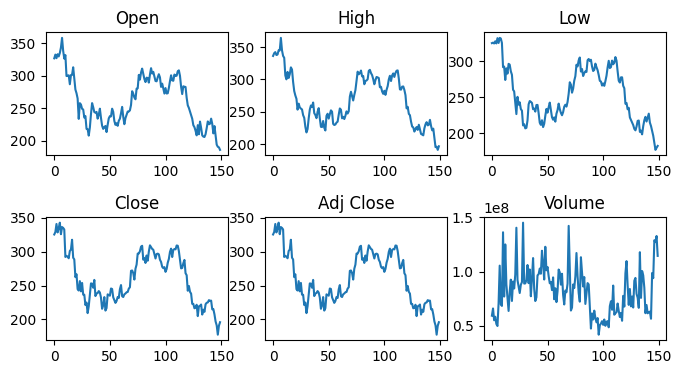

In [8]:
cols = list(df.columns)

plt.figure(figsize=(8,4))
plt.subplots_adjust(hspace=0.5)

for i, column in enumerate(cols[1:]):
    plt.subplot(2, 3, i+1)
    df[column].plot()
    plt.title(column)

plt.show()

Graficando cada variable contra el tiempo, se observa que todas las variables menos el volumen siguen una tendencia casi idéntica, menos el volumen. Se procede a visualizar una matriz de correlaciones entre las variables para comprobar la existencia de correlación. 

<AxesSubplot: >

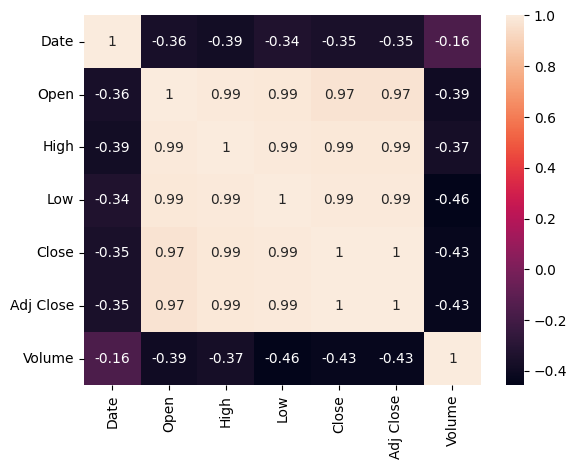

In [9]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)

Este mapa de calor proporciona una visión general de la correlación entre las variables del dataset. Salta a la vista la fuerte correlación (por no decir correlación casi perfecta) de todas las variables del dataset, menos el volumen. 

Esto es debido a que todas las variables menos el volumen son indicadores del precio de la misma cosa, en este caso el precio de la acción. Esto quiere decir que si el precio de las acciones de tesla sigue una tendencia alcista a diferentes plazos, es normal que el precio de apertura, máximo, mínimo y cierre fluctúen en la misma dirección.

Por otra parte, el volumen sigue una tendencia completamente distinta, ya que es un indicador de una variable completamente diferente (el volumen de acciones negociadas). Presenta una correlación negativa con el resto de variables, de especial intensidad con las variables de precio más bajo en un día y de cierre, tanto sin ajustar como ajustada. Si se aplica un poco de teoría de finanzas, se encuentra que la correlación negativa es una señal de debilidad. Esto quiere decir que cuando el precio de la acción sube, el volumen de transacciones baja, y viceversa. Esto puede ser debido a que los inversores no están seguros de la tendencia del precio de la acción o que existe un alto interés de venta de la acción.